In [80]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler

from pandas import read_csv
mpl.rcParams['lines.linewidth'] = 2.2
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['font.sans-serif'] = ['Arial', 'Tahoma', 'DejaVu Sans', 'Lucida Grande', 'Verdana']
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = '#636363'
mpl.rcParams['grid.alpha'] = 0.12
mpl.rcParams['grid.linewidth'] = 0.7
mpl.rcParams['grid.linestyle'] = '-'
mpl.rcParams['axes.prop_cycle'] = cycler('color',  ['#0AB34F', '#bf009f', '#00abc3', '#8e92c5', '#cc7014', '#e32851'])
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.framealpha'] = 0.6
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['figure.figsize'] = 8, 4.9443
mpl.rcParams['figure.dpi'] = 100

from ucla.core.constants import *
from ucla.core.local_ODE_solver import AALocalModel
from ucla.core.physics import SMT

from scipy.interpolate import RegularGridInterpolator


In [81]:
nn_invcc_at_Pbar_TK = lambda Pbar, TK: Pbar*bar_to_AU/(TK*K_to_AU)*AU_to_invcc

T_room_K = 290
Xe_nn_invcc = nn_invcc_at_Pbar_TK(5, T_room_K)
He_nn_invcc = nn_invcc_at_Pbar_TK(74, T_room_K)
Ar_nn_invcc = nn_invcc_at_Pbar_TK(25, T_room_K)

Xe_ionization_energies_eV = np.array([0, 12.1298437, 20.975, 31.05, 42.20 , 54.1, 66.703, 91.6, 105.9778, 179.84, 202.0, 229.02])
Ar_ionization_energies_eV = np.array([0, 15.7596119, 27.62967, 40.735, 59.58, 74.84, 91.290])
He_ionization_energies_eV = np.array([0, 24.587389011, 54.4177655282])

print(f"Xe ne = {Xe_nn_invcc:0.3e} [1/cc] ")
print(f"He ne = {He_nn_invcc:0.3e} [1/cc] ") 
print(f"Ar ne = {Ar_nn_invcc:0.3e} [1/cc] ")

Xe_TK_peak = 16.60952380952381e3 # 0 ns?
He_TK_peak = 14.790528233151186e3 # 0.0031746031746031746 ns
Ar_TK_peak = 17.761029411764707e3 # 0.008097165991902834 ns?

Xe ne = 1.249e+20 [1/cc] 
He ne = 1.848e+21 [1/cc] 
Ar ne = 6.244e+20 [1/cc] 


### Element Information

In [82]:
element='Ar'

if element=='Xe':
    Z, A = 54, 131
    n_i = Xe_nn_invcc *1e6
    m_i = A*m_p
    r_i = 1/(4/3*π*n_i)**(1/3)*m_to_AU
    
    Ti_init = 300 # K
    Te_init = Xe_TK_peak # K

    χ0_eV = 12.1298437  # eV See 
    χ0_J = χ0_eV*eV_to_J

    ionization_file="../../data/Xe5bar_Saha.txt"
    element_data_file = "../../data/experimental_data/Xe_5bar_Te.txt"
    N_n, N_T = 20, 200
    tmax=18e-9
    dt=1e-10
    

elif element=='He':
    Z, A = 2, 4
    n_i = He_nn_invcc *1e6
    m_i = A*m_p
    r_i = 1/(4/3*π*n_i)**(1/3)*m_to_AU

    Ti_init = 300 # K
    Te_init = He_TK_peak # K

    χ0_eV = 24.587389011  # eV See 
    χ0_J = χ0_eV*eV_to_J

    ionization_file="../../data/He74bar_Saha.txt"
    element_data_file = "../../data/experimental_data/He_74bar_Te.txt"

    N_n, N_T = 20, 200
    tmax=1e-9
    dt=1e-11

    
elif element=='Ar':
    Z, A = 18, 39.948
    n_i = Ar_nn_invcc *1e6
    m_i = A*m_p
    r_i = 1/(4/3*π*n_i)**(1/3)*m_to_AU

    Ti_init = 300 # K
    Te_init = Ar_TK_peak # K

    χ0_eV = 15.7596119  # eV See 
    χ0_J = χ0_eV*eV_to_J

    ionization_file="../../data/Ar25bar_Saha.txt"
    element_data_file = "../../data/experimental_data/Ar_25bar_Te.txt"

    N_n, N_T = 20, 200
    tmax=4.5e-9
    dt=1e-11


print(f"Cold pressure: P_cold = {n_i*Ti_init*k_B * Pa_to_AU*AU_to_bar:0.3f} bar = {n_i*Ti_init*k_B * 1e-9:0.3f} GPa ")
print(f"Hot pressure: P_hot = {n_i*Te_init*k_B * Pa_to_AU*AU_to_bar:0.3f} bar = {n_i*Te_init*k_B * 1e-9:0.3f} GPa ")
print(f"Density: ρ = {n_i*m_i:0.3f} [kg/m^3] =  {1e-3*n_i*m_i:0.3f} [g/cm^3] ")
print(f"Ion sphere radius: r_i = {r_i:0.3f} [au]")


Cold pressure: P_cold = 25.862 bar = 0.003 GPa 
Hot pressure: P_hot = 1531.124 bar = 0.153 GPa 
Density: ρ = 41.655 [kg/m^3] =  0.042 [g/cm^3] 
Ion sphere radius: r_i = 13.716 [au]


In [92]:
from scipy.interpolate import interp1d

include_xc = True

if include_xc==True:
    aa_eos_dat = read_csv("/home/zach/plasma/saha/data/Ar_IS_simplexc_noW_2024-08-05/Ar_EOS.dat", delim_whitespace=True, header=0)
else:
    aa_eos_dat = read_csv("/home/zach/plasma/saha/data/Ar_IS_noxc_noW_2024-08-05/Ar_EOS.dat", delim_whitespace=True, header=0)
    
aa_T_array = np.array(aa_eos_dat['T[K]'])
aa_Ee_array = np.array(aa_eos_dat['Ee[AU]'])*AU_to_J*n_i
aa_Pe_array = np.array(aa_eos_dat['Pe[AU]'])
aa_Zbar_array = np.array(aa_eos_dat['Zbar'])

Ee_func = interp1d(aa_T_array, aa_Ee_array)
Zbar_func = interp1d(aa_T_array, aa_Zbar_array)

# resort to interpolate Te(Ee)
sorted_args = np.argsort(aa_Ee_array)
aa_T_array_sort, aa_Ee_array_sort = aa_T_array[sorted_args], aa_Ee_array[sorted_args]

Te_func = interp1d(aa_Ee_array_sort, aa_T_array_sort)

In [93]:
plasma = AALocalModel(Z, m_i,  Ti_init, Te_init, n_i, Zbar_func=Zbar_func, Ee_func=Ee_func, Te_func=Te_func)
plasma.solve_ode(tmax=tmax, dt=dt)

In [94]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
Element_data = read_csv(element_data_file, delim_whitespace=True, header=1)

def plot_temperatures(plasma, figax=None,title='', x_label=True, y_label=True):
    if figax is None:
        fig, ax = plt.subplots(figsize=(10,8), facecolor='white')
    else:
        fig, ax = figax 
    # fig.suptitle(r"Local Simulation : $G \times {}$".format(plasma.G_rescale), fontsize=20)
    # fig.suptitle(r"Local Simulation ".format(plasma.G_rescale), fontsize=20)

    dense_t_list = np.linspace(0,18,num=100)

    # Plot Te
    #Data and fit
    # ax.plot(Xe_data['t[ns]'], Texp_fit_form(Xe_data['t[ns]'],*Te_vals), 'r--', label='Experiment Data')
    ax.plot(Element_data['t[ns]'], Element_data['T[kK]'], 'rx', label='Experiment Data')
    ax.plot(plasma.t_saved_list*1e9, plasma.Te_list/1e3,  label=r'Simulation $T_e$')
    ax.plot(plasma.t_saved_list*1e9, plasma.Ti_list/1e3,'--',  label=r'Simulation $T_i$')


    if y_label: 
        ax.set_ylabel(r'$T_e$ [kK]', fontsize=20, color='r')
    else:
        ax.tick_params(axis='y',which='both',left=False,labelleft=False)
    if x_label:
        ax.set_xlabel('t [ns]', fontsize=20)
    else:
        ax.tick_params(axis='x',bottom=False,labelbottom=False)
    
    # ax.set_xlim(0,12)

    ax.set_ylim(0,19)
    ax.tick_params(labelsize=20)
    ax.tick_params(axis='y',color='r', labelcolor='r')

    ax.set_title(title)
    # ax.legend(handles=legend_elements, loc='upper right')
    ax.legend(loc='center right')
    return fig, ax

(<Figure size 1000x800 with 1 Axes>,
 <Axes: xlabel='t [ns]', ylabel='$T_e$ [kK]'>)

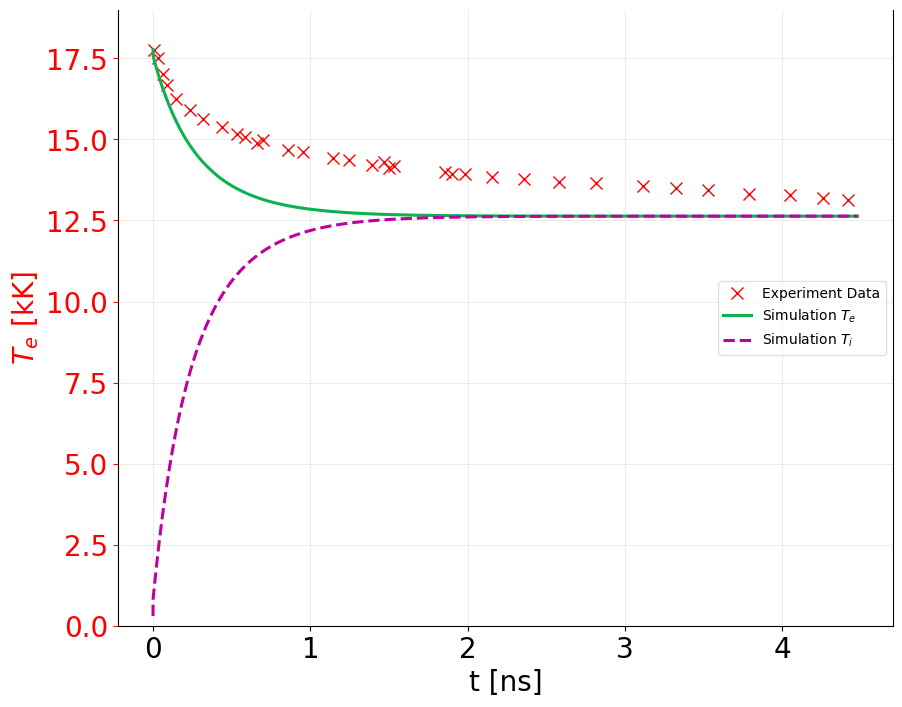

In [95]:
plot_temperatures(plasma)

AttributeError: 'list' object has no attribute 't_saved_list'

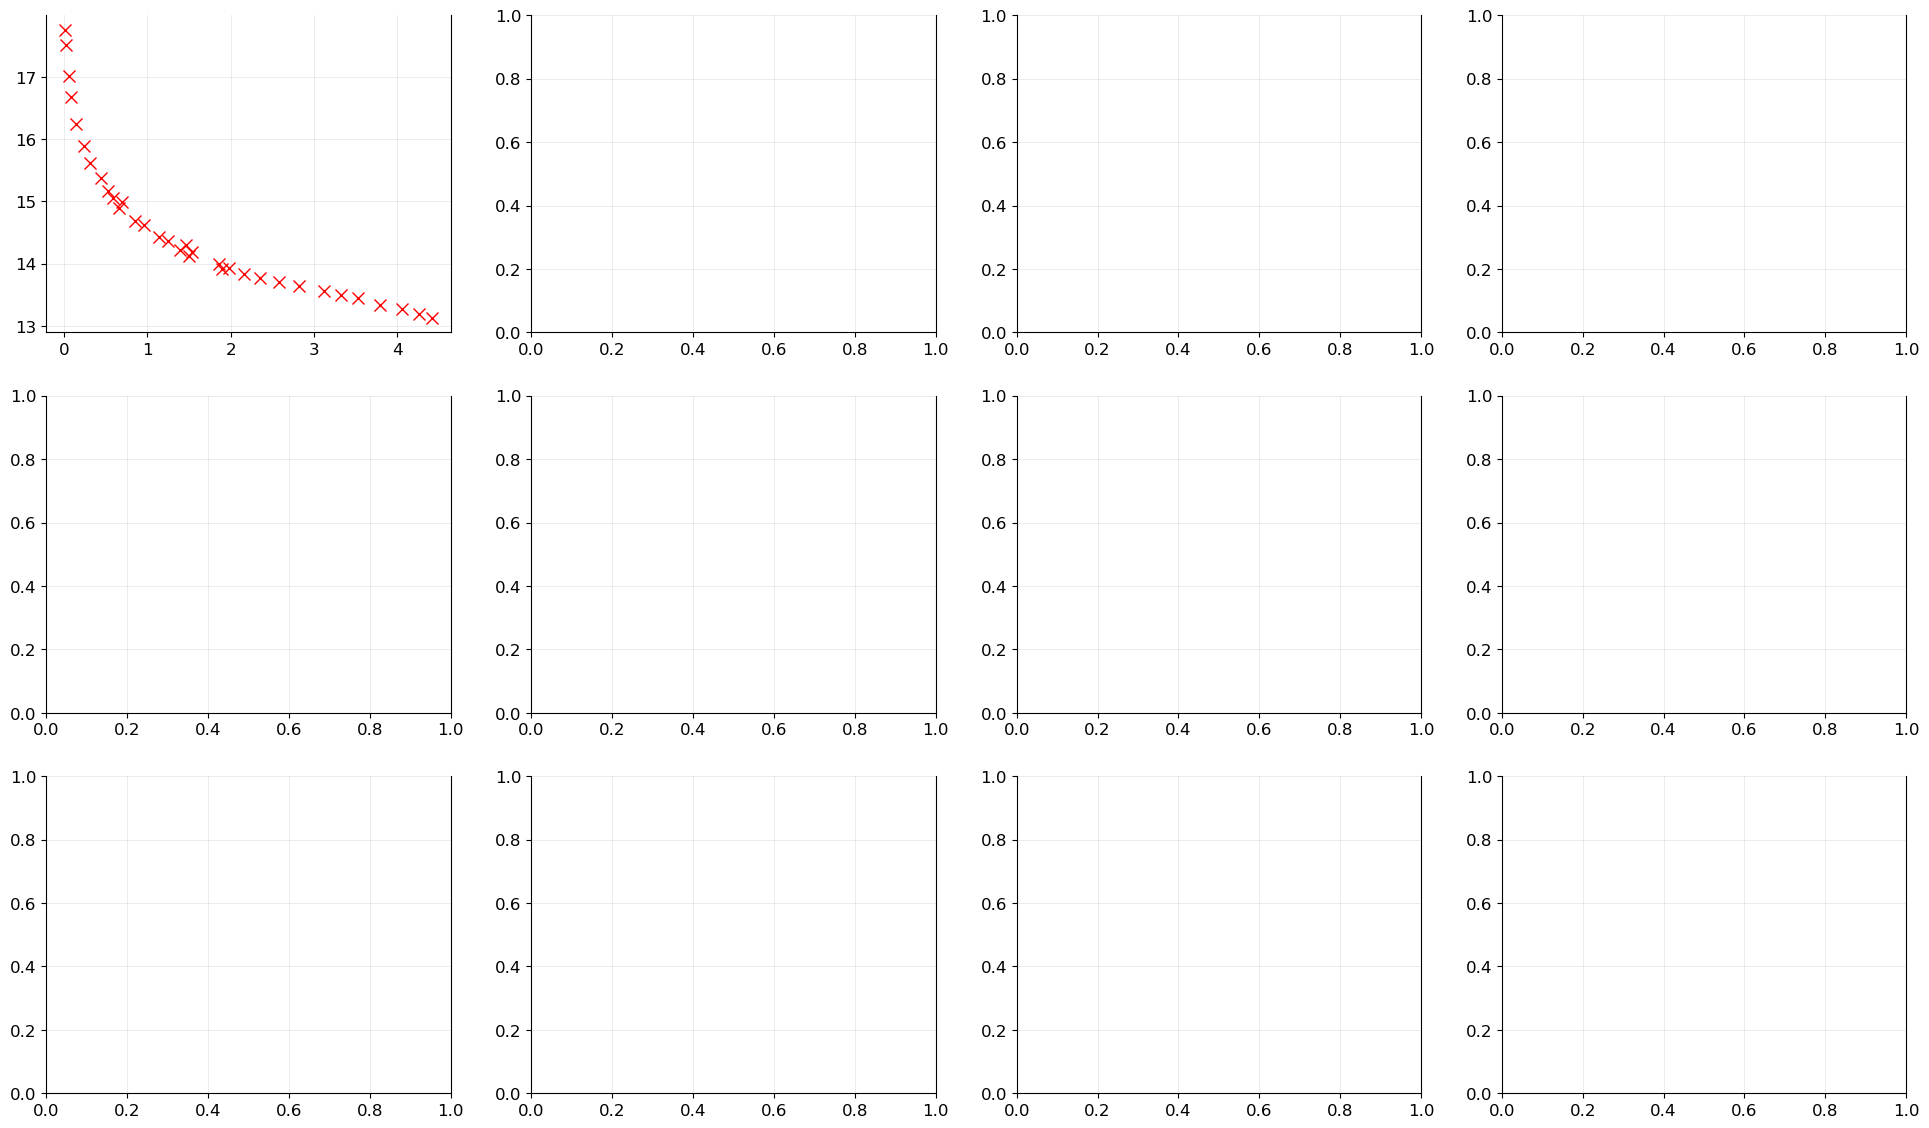

In [91]:
fig, axs = plt.subplots(3,4, figsize=(24,14))


for i, χ_rescale in enumerate(χ_rescale_list):
    for j, Zbar_rescale in enumerate(Zbar_rescale_list):
        plasma = plasma_list[i][j]
        if i==len(χ_rescale_list)-1:
            x_label=True
        else:
            x_label=False
        if j==0:
            y_label=True
        else: 
            y_label= False
        plot_temperatures(plasma, figax=(fig, axs[i,j]), title=f"Rescale χ x {χ_rescale}, Zbar x {Zbar_rescale}" ,x_label=x_label, y_label=y_label)
plt.tight_layout()
plt.savefig('../../media/{element}_Local_simulation_scaling_results.png', dpi=200)

### Fitting Attempt

In [ ]:
from scipy.optimize import minimize
from scipy.interpolate import interp1d

def func_to_min_to_model_data(rescale_array):
    G_rescale, χ_rescale, Zbar_rescale = rescale_array
    
    Zbar_func, χ_func = make_ionization_function(Z, n_i, χ_rescale = χ_rescale, Zbar_rescale = Zbar_rescale)

    # LocalModel(Z, m_i, Ti_init, Te_init, n_i, Zbar_func = None, χ_func = None, transport_model = "SMT"):
    plasma = LocalModel(Z, m_i,  Ti_init, Te_init, n_i, Zbar_func=Zbar_func, χ_func=χ_func, G_rescale = G_rescale )
    plasma.solve_ode(tmax=tmax, dt=dt)
    sim_Te_at_data_points = interp1d( plasma.t_saved_list*1e9, plasma.Te_list/1e3 )(Element_data['t[ns]'])
    return np.linalg.norm(sim_Te_at_data_points - Element_data['T[kK]'])

sol = minimize(func_to_min_to_model_data, (1, 0.1, 3), bounds=( (1,1),  (0,1),  (0,20) )   )
rescale_optimal_array = sol.x
sol

In [ ]:

Zbar_func, χ_func = make_ionization_function(Z, n_i, χ_rescale = rescale_optimal_array[1], Zbar_rescale = rescale_optimal_array[2])

plasma_optimized = LocalModel(Z, m_i,  Ti_init, Te_init, n_i, Zbar_func=Zbar_func, χ_func=χ_func, G_rescale = rescale_optimal_array[0] )
plasma_optimized.solve_ode(tmax=tmax, dt=dt)

In [ ]:
_, ax = plot_temperatures(plasma_optimized)

props = dict(boxstyle='round', facecolor='w', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.15, 0.95, r'Optimal (G, $\chi$, $\langle Z \rangle$) $\times$ ({0:0.1f}, {1:0.2f}, {2:0.2f})'.format(*rescale_optimal_array), transform=ax.transAxes, fontsize=14, bbox=props)


In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

t_slice = slice(2,None) 


Γ_list =  plasma_optimized.Zbar_list**2/(plasma_optimized.Ti_list*K_to_AU * r_i)

_, χ_tmp_func = make_ionization_function(Z, n_i, χ_rescale = rescale_optimal_array[1], Zbar_rescale = rescale_optimal_array[2])
χ_list = χ_tmp_func(plasma_optimized.Te_list)*J_to_eV

param_list = [plasma_optimized.Te_list[t_slice],  plasma_optimized.Ti_list[t_slice],  plasma_optimized.Zbar_list[t_slice], plasma_optimized.G_list[t_slice],
              Γ_list[t_slice], χ_list[t_slice] ]
name_list = ['T_e', 'T_i', 'Zbar', 'G', '\Gamma','\chi']
unit_list = ['[K]','[K]','','[k$_B$/m$^{3}$s]','','[eV]']
linestyles= ['-','-','--',':','x', '^']

for param, name, unit, line in zip( param_list, name_list, unit_list, linestyles):
    var_max = np.max(param)
    ax.plot(plasma_optimized.t_saved_list[t_slice]*1e9, param/var_max,line, label=r'${0}/${1:0.2e} {2}'.format(name, var_max, unit))


ax.legend(fontsize=10)
# ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel("x/max(x)")
ax.set_xlabel("t [ns]")



In [ ]:

rescalers = 1,0,1 # G, χ, Zbar

Zbar_func, χ_func = make_ionization_function(Z, n_i, χ_rescale = rescalers[1], Zbar_rescale = rescalers[2])

plasma = LocalModel(Z, m_i,  Ti_init, Te_init, n_i, Zbar_func=Zbar_func, χ_func=χ_func, G_rescale = rescalers[0] )
plasma.solve_ode(tmax=18e-9, dt=1e-10)

In [ ]:
fig, ax = plt.subplots()

τei = 1/(plasma.G_list[t_slice]/(3/2*k_B*n_i))*1e9
τie = 1/(plasma.G_list[t_slice]/(3/2*k_B*n_i*plasma.Zbar_list[t_slice] ))*1e9

# ax.plot(plasma.t_saved_list[t_slice]*1e9, τei*plasma.Zbar_list[t_slice], label=r'$x (3/2 k_B n_i)/G$')
# ax.plot(plasma.t_saved_list[t_slice]*1e9, τie*plasma.Zbar_list[t_slice], label=r'$x (3/2 k_B n_e)/G$')
ax.plot(plasma.t_saved_list[t_slice]*1e9, plasma.Zbar_list[t_slice])

ax.set_ylabel(r'$\tau_{ei} [ns]$')
ax.set_ylabel(r'$x$')
ax.set_xlabel(r"$t$ [ns]")
# ax.set_title("Ion temperature relaxation time")
ax.set_title("Ionization fraction")
ax.legend(fontsize=14)


In [ ]:
fig, ax = plt.subplots()

τei = 1/(plasma.G_list[t_slice]/(3/2*k_B*n_i))*1e9
τie = 1/(plasma.G_list[t_slice]/(3/2*k_B*n_i*plasma.Zbar_list[t_slice] ))*1e9

ax.plot(plasma.t_saved_list[t_slice]*1e9, τei, label=r'$(3/2 k_B n_i)/G$')
ax.plot(plasma.t_saved_list[t_slice]*1e9, τie, label=r'$(3/2 k_B n_e)/G$')

# ax.plot(plasma.t_saved_list[t_slice]*1e9, τei*plasma.Zbar_list[t_slice] , label=r'$x (3/2 k_B n_i)/G$')
# ax.plot(plasma.t_saved_list[t_slice]*1e9, τie*plasma.Zbar_list[t_slice] , label=r'$x (3/2 k_B n_e)/G$')

ax.set_ylabel(r'$\tau_{ei} [ns]$')
ax.set_xlabel(r"$t$ [ns]")
ax.set_title("Ion temperature relaxation time")
# ax.set_title("Electron temperature relaxation time")
# ax.set_yscale('log')
ax.legend(fontsize=14)


In [ ]:
_, ax = plot_temperatures(plasma)

props = dict(boxstyle='round', facecolor='w', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.3, 0.98, r'(G, $\chi$, $\langle Z \rangle$) $\times$ ({0:0.1f}, {1:0.2f}, {2:0.2f})'.format(*rescalers), transform=ax.transAxes, fontsize=14, bbox=props)


### Allowing Ti initial to vary

In [ ]:
from scipy.optimize import minimize
from scipy.interpolate import interp1d

Ti_fixed_rescale = 3000/300
def func_to_min_to_model_data(rescale_array):
    G_rescale, χ_rescale, Zbar_rescale, Ti_rescale = rescale_array

    Zbar_func, χ_func = make_ionization_function(Z, n_i, χ_rescale = χ_rescale, Zbar_rescale = Zbar_rescale)
    Ti_rescale = Ti_fixed_rescale
    
    # LocalModel(Z, m_i, Ti_init, Te_init, n_i, Zbar_func = None, χ_func = None, transport_model = "SMT"):
    plasma = LocalModel(Z, m_i,  Ti_init*Ti_rescale, Te_init, n_i, Zbar_func=Zbar_func, χ_func=χ_func, G_rescale = G_rescale )
    plasma.solve_ode(tmax=18e-9, dt=1e-10)
    sim_Te_at_data_points = interp1d( plasma.t_saved_list*1e9, plasma.Te_list/1e3 )(Xe_data['t[ns]'])
    return np.linalg.norm(sim_Te_at_data_points - Xe_data['T[kK]'])

sol = minimize(func_to_min_to_model_data,  (5, 0.01, 0.70, 7), bounds=( (0,10),  (0,1),  (0,1.4), (0, 30) )   )
rescale_optimal_array = sol.x
rescale_optimal_array[-1] = Ti_fixed_rescale
sol

In [ ]:

Zbar_func, χ_func = make_ionization_function(Z, n_i, χ_rescale = rescale_optimal_array[1], Zbar_rescale = rescale_optimal_array[2])

plasma_optimized = LocalModel(Z, m_i,  Ti_init*rescale_optimal_array[3], Te_init, n_i, Zbar_func=Zbar_func, χ_func=χ_func, G_rescale = rescale_optimal_array[0] )
plasma_optimized.solve_ode(tmax=18e-9, dt=1e-10)

In [ ]:
_, ax = plot_temperatures(plasma_optimized)

props = dict(boxstyle='round', facecolor='w', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.15, 0.95, r'Optimal ($T_i^{{\rm init}} $, G, $\chi$, $\langle Z \rangle$) $\times$ ({3:0.1f} [K], {0:0.1f}, {1:0.2f}, {2:0.2f})'.format(*rescale_optimal_array[:3],rescale_optimal_array[-1]*Ti_init), transform=ax.transAxes, fontsize=14, bbox=props)
